In [10]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve
)

import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import warnings
warnings.filterwarnings("ignore")

In [11]:
df = pd.read_csv("human_vital_signs_dataset_2024.csv")
print("Dataset Shape:", df.shape)

Dataset Shape: (200020, 17)


In [12]:
features = [
    'Heart Rate',
    'Body Temperature',
    'Oxygen Saturation',
    'Systolic Blood Pressure',
    'Diastolic Blood Pressure',
    'Age',
    'Gender',
    'Weight (kg)',
    'Height (m)',
    'Derived_BMI'
]

target = 'Risk Category'


In [13]:
# Encode Gender
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})

# Encode target
label_encoder = LabelEncoder()
df['Risk_Encoded'] = label_encoder.fit_transform(df[target])

print("Target Encoding:")
for cls, val in zip(label_encoder.classes_, range(len(label_encoder.classes_))):
    print(f"{cls} -> {val}")


Target Encoding:
High Risk -> 0
Low Risk -> 1


In [14]:
X = df[features]
y = df['Risk_Encoded']


In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])


Training samples: 160016
Testing samples: 40004


In [16]:
numerical_features = [
    'Heart Rate', 'Body Temperature', 'Oxygen Saturation',
    'Systolic Blood Pressure', 'Diastolic Blood Pressure',
    'Age', 'Weight (kg)', 'Height (m)', 'Derived_BMI'
]

scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_features] = scaler.fit_transform(
    X_train[numerical_features]
)
X_test_scaled[numerical_features] = scaler.transform(
    X_test[numerical_features]
)


In [17]:
dt_models = {
    "Decision Tree (Default)": DecisionTreeClassifier(
        random_state=42
    ),

    "Decision Tree (Balanced)": DecisionTreeClassifier(
        class_weight='balanced',
        random_state=42
    ),

    "Decision Tree (Pruned)": DecisionTreeClassifier(
        max_depth=6,
        min_samples_split=10,
        min_samples_leaf=5,
        class_weight='balanced',
        random_state=42
    )
}


In [18]:
results = {}

for name, model in dt_models.items():
    print(f"\nTraining {name}...")

    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]

    results[name] = {
        "model": model,
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_proba)
    }

    print(f"Accuracy: {results[name]['accuracy']:.4f}")
    print(f"F1-score: {results[name]['f1']:.4f}")
    print(f"ROC-AUC: {results[name]['roc_auc']:.4f}")



Training Decision Tree (Default)...
Accuracy: 1.0000
F1-score: 1.0000
ROC-AUC: 1.0000

Training Decision Tree (Balanced)...
Accuracy: 1.0000
F1-score: 1.0000
ROC-AUC: 1.0000

Training Decision Tree (Pruned)...
Accuracy: 1.0000
F1-score: 1.0000
ROC-AUC: 1.0000


In [19]:
best_model_name = max(results, key=lambda x: results[x]['roc_auc'])
best_model = results[best_model_name]['model']

print("\nBest Decision Tree Model:", best_model_name)



Best Decision Tree Model: Decision Tree (Default)



Classification Report:
              precision    recall  f1-score   support

   High Risk       1.00      1.00      1.00     21023
    Low Risk       1.00      1.00      1.00     18981

    accuracy                           1.00     40004
   macro avg       1.00      1.00      1.00     40004
weighted avg       1.00      1.00      1.00     40004



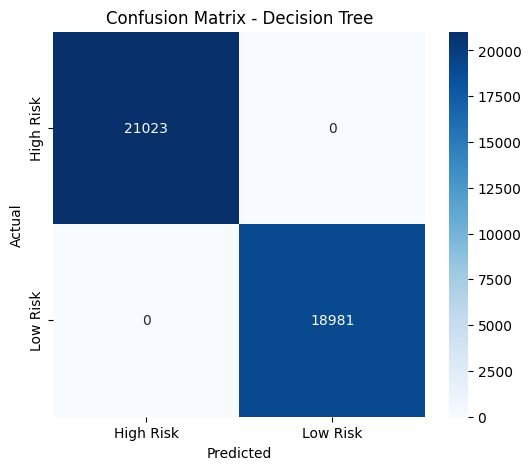

In [20]:
y_pred_best = best_model.predict(X_test_scaled)
y_proba_best = best_model.predict_proba(X_test_scaled)[:, 1]

print("\nClassification Report:")
print(classification_report(
    y_test,
    y_pred_best,
    target_names=label_encoder.classes_
))

cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Decision Tree")
plt.show()


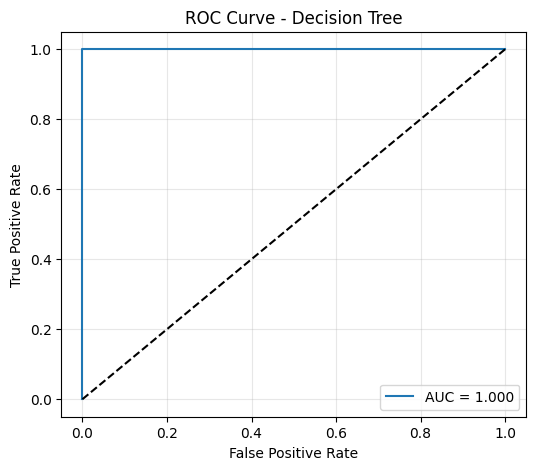

In [21]:
fpr, tpr, _ = roc_curve(y_test, y_proba_best)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {results[best_model_name]['roc_auc']:.3f}")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Decision Tree")
plt.legend()
plt.grid(alpha=0.3)
plt.show()



Feature Importance:
                    Feature  Importance
9               Derived_BMI    0.737535
0                Heart Rate    0.262465
1          Body Temperature    0.000000
2         Oxygen Saturation    0.000000
4  Diastolic Blood Pressure    0.000000
3   Systolic Blood Pressure    0.000000
5                       Age    0.000000
6                    Gender    0.000000
7               Weight (kg)    0.000000
8                Height (m)    0.000000


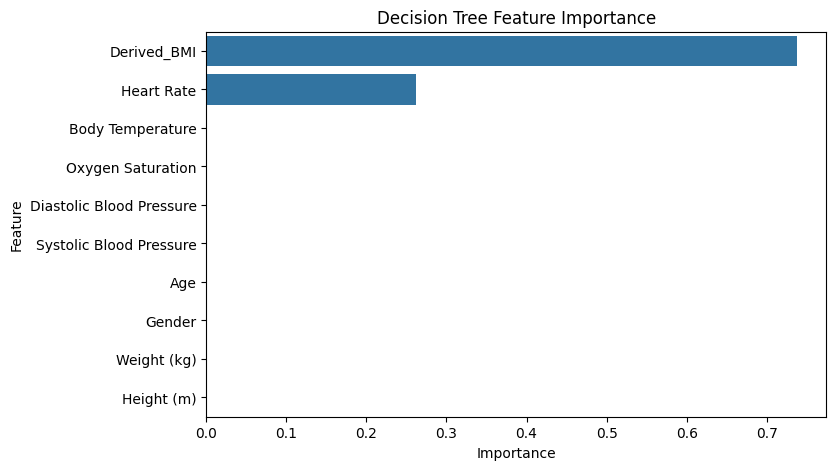

In [22]:
feature_importance = pd.DataFrame({
    "Feature": features,
    "Importance": best_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("\nFeature Importance:")
print(feature_importance)

plt.figure(figsize=(8,5))
sns.barplot(
    x="Importance",
    y="Feature",
    data=feature_importance
)
plt.title("Decision Tree Feature Importance")
plt.show()
